In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import shutil
from shutil import copy
from collections import defaultdict
import tensorflow as tf
import keras.backend as K
from patchify import patchify, unpatchify
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [3]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor,mask_type):

    for image_path in glob.glob(f'Images for model/{mask_type}/{dataset_type}_images/{dataset_type}/*.png'):
        mask_suffix = f'_{mask_type}_mask.tif'
        path = f'Images for model/{mask_type}'
        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)

        image = cv2.imread(image_path)
        image = padder(image, patch_size)
        if scaling_factor != 1:
            image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 3)

        image_patch_path = image_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            image_patch_path_numbered = f'{image_patch_path[:-4]}_{i}.png'
            cv2.imwrite(image_patch_path_numbered, patch)

        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)
        mask = cv2.imread(mask_path, 0)
        mask = padder(mask, patch_size)
        if scaling_factor != 1:
            mask = cv2.resize(mask, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(mask, (patch_size, patch_size), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        mask_patch_path = mask_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            mask_patch_path_numbered = f'{mask_patch_path[:-4]}_{i}.png'
            cv2.imwrite(mask_patch_path_numbered, patch)

----

Modeling

In [4]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [5]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1, iou])
    model.summary()
    
    return model

In [6]:
patch_size = 128
scaling_factor = 1


Training model for roots

In [7]:
mask_type = 'root'

In [8]:
patch_dir = 'Images for model/root_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [9]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)

In [10]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Training masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.


In [11]:
from keras.callbacks import EarlyStopping
model_root = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_iou',
                   patience=2,
                   restore_best_weights='True',
                   mode='max')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

-----

In [12]:
from keras.optimizers import Adam
def compile_model(model, lr):
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy', 'f1', 'iou'])
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss = 'binary_crossentropy',metrics=['accuracy', 'f1', 'iou'])
    return model

In [13]:
def compile_model(model, lr=0.001):
    # Assuming 'iou', 'f1', 'accuracy' are the metrics you want to include\\
    optimizer = Adam(lr=lr) 
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1, iou])  # Include all four metrics here
    return model

In [14]:
cb = EarlyStopping(monitor='val_iou',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
histories = [] # for plotting val_loss vs epochs for each learning rate
best_val_ious = [] # for plotting best_val_loss vs learning rate
for lr in learning_rates:
    print('Training with: ', lr)
    model_root = simple_unet_model(patch_size, patch_size, 1)
    model_root = compile_model(model_root, lr=lr)

    H = model_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb])   
 
       
    best_metrics = model_root.evaluate(val_generator, steps=val_image_generator.samples // 16)
    
    best_val_iou = best_metrics[3]  
    best_val_ious.append(best_val_iou)
    histories.append(H.history["val_loss"])

Training with:  0.01
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 16  0           ['conv2d_19[0][0]']              
                                )                                      

 conv2d_transpose_5 (Conv2DTran  (None, 32, 32, 64)  32832       ['conv2d_30[0][0]']              
 spose)                                                                                           
                                                                                                  
 concatenate_5 (Concatenate)    (None, 32, 32, 128)  0           ['conv2d_transpose_5[0][0]',     
                                                                  'conv2d_24[0][0]']              
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 64)   73792       ['concatenate_5[0][0]']          
                                                                                                  
 dropout_15 (Dropout)           (None, 32, 32, 64)   0           ['conv2d_31[0][0]']              
                                                                                                  
 conv2d_32

c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1980/1980 [==============================] - 129s 60ms/step - loss: 0.0471 - accuracy: 0.9936 - f1: 5.4363e-04 - iou: 0.0857 - val_loss: 0.0146 - val_accuracy: 0.9975 - val_f1: 0.0000e+00 - val_iou: 0.0132
Epoch 2/50
1980/1980 [==============================] - 123s 62ms/step - loss: 0.0224 - accuracy: 0.9944 - f1: 0.1202 - iou: 0.0408 - val_loss: 0.0111 - val_accuracy: 0.9975 - val_f1: 0.1914 - val_iou: 0.2012
Epoch 3/50
1980/1980 [==============================] - 118s 60ms/step - loss: 0.0199 - accuracy: 0.9948 - f1: 0.2265 - iou: 0.0912 - val_loss: 0.0096 - val_accuracy: 0.9979 - val_f1: 0.2128 - val_iou: 0.3092
Epoch 4/50
1980/1980 [==============================] - 118s 60ms/step - loss: 0.0170 - accuracy: 0.9952 - f1: 0.3129 - iou: 0.0851 - val_loss: 0.0107 - val_accuracy: 0.9972 - val_f1: 0.2826 - val_iou: 0.1784
Epoch 5/50
1980/1980 [==============================] - 118s 60ms/step - loss: 0.0146 - accuracy: 0.9957 - f1: 0.4060 - iou: 0.1375 - val_loss: 0.0095 - val_accuracy: 

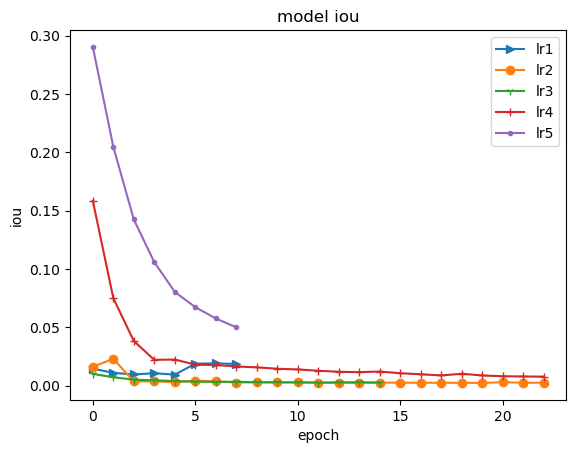

In [15]:
plt.plot(histories[0], marker = ">")
plt.plot(histories[1], marker = "o")
plt.plot(histories[2], marker = "1")
plt.plot(histories[3], marker = "+")
plt.plot(histories[4], marker = ".")
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['lr1', 'lr2', 'lr3', 'lr4', 'lr5'], loc='upper right')
plt.show()

----


In [16]:
h = model_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=10,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/10
1980/1980 [==============================] - 124s 63ms/step - loss: 0.0386 - accuracy: 0.9941 - f1: 2.9826e-04 - iou: 0.0024 - val_loss: 0.1003 - val_accuracy: 0.9976 - val_f1: 7.1067e-04 - val_iou: 0.0064
Epoch 2/10
1980/1980 [==============================] - 123s 62ms/step - loss: 0.0355 - accuracy: 0.9941 - f1: 1.1809e-04 - iou: 0.0023 - val_loss: 0.0791 - val_accuracy: 0.9973 - val_f1: 0.0000e+00 - val_iou: 0.0064
Epoch 3/10
1980/1980 [==============================] - 123s 62ms/step - loss: 0.0341 - accuracy: 0.9941 - f1: 1.0415e-05 - iou: 0.0023 - val_loss: 0.0637 - val_accuracy: 0.9975 - val_f1: 0.0000e+00 - val_iou: 0.0053
Epoch 4/10
1980/1980 [==============================] - 123s 62ms/step - loss: 0.0331 - accuracy: 0.9941 - f1: 2.8057e-06 - iou: 0.0023 - val_loss: 0.0558 - val_accuracy: 0.9974 - val_f1: 0.0000e+00 - val_iou: 0.0050
Epoch 5/10
1980/1980 [==============================] - 155s 78ms/step - loss: 0.0323 - accuracy: 0.9942 - f1: 1.5685e-06 - iou: 0.0

25/25 [==============================] - 6s 93ms/step


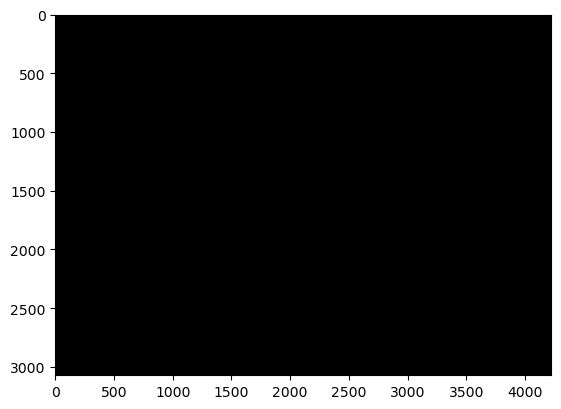

In [17]:
image_path = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\roots\train_images\train\002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected.png'
image = cv2.imread(image_path)
image = padder(image, patch_size)

patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)

i = patches.shape[0]
j = patches.shape[1]

patches = patches.reshape(-1, patch_size, patch_size, 1)
patches.shape

preds = model_root.predict(patches/255)

preds = preds.reshape(i, j, 128, 128)

predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
plt.imshow(predicted_mask>0.5, cmap='gray')

25/25 [==============================] - 1s 46ms/step


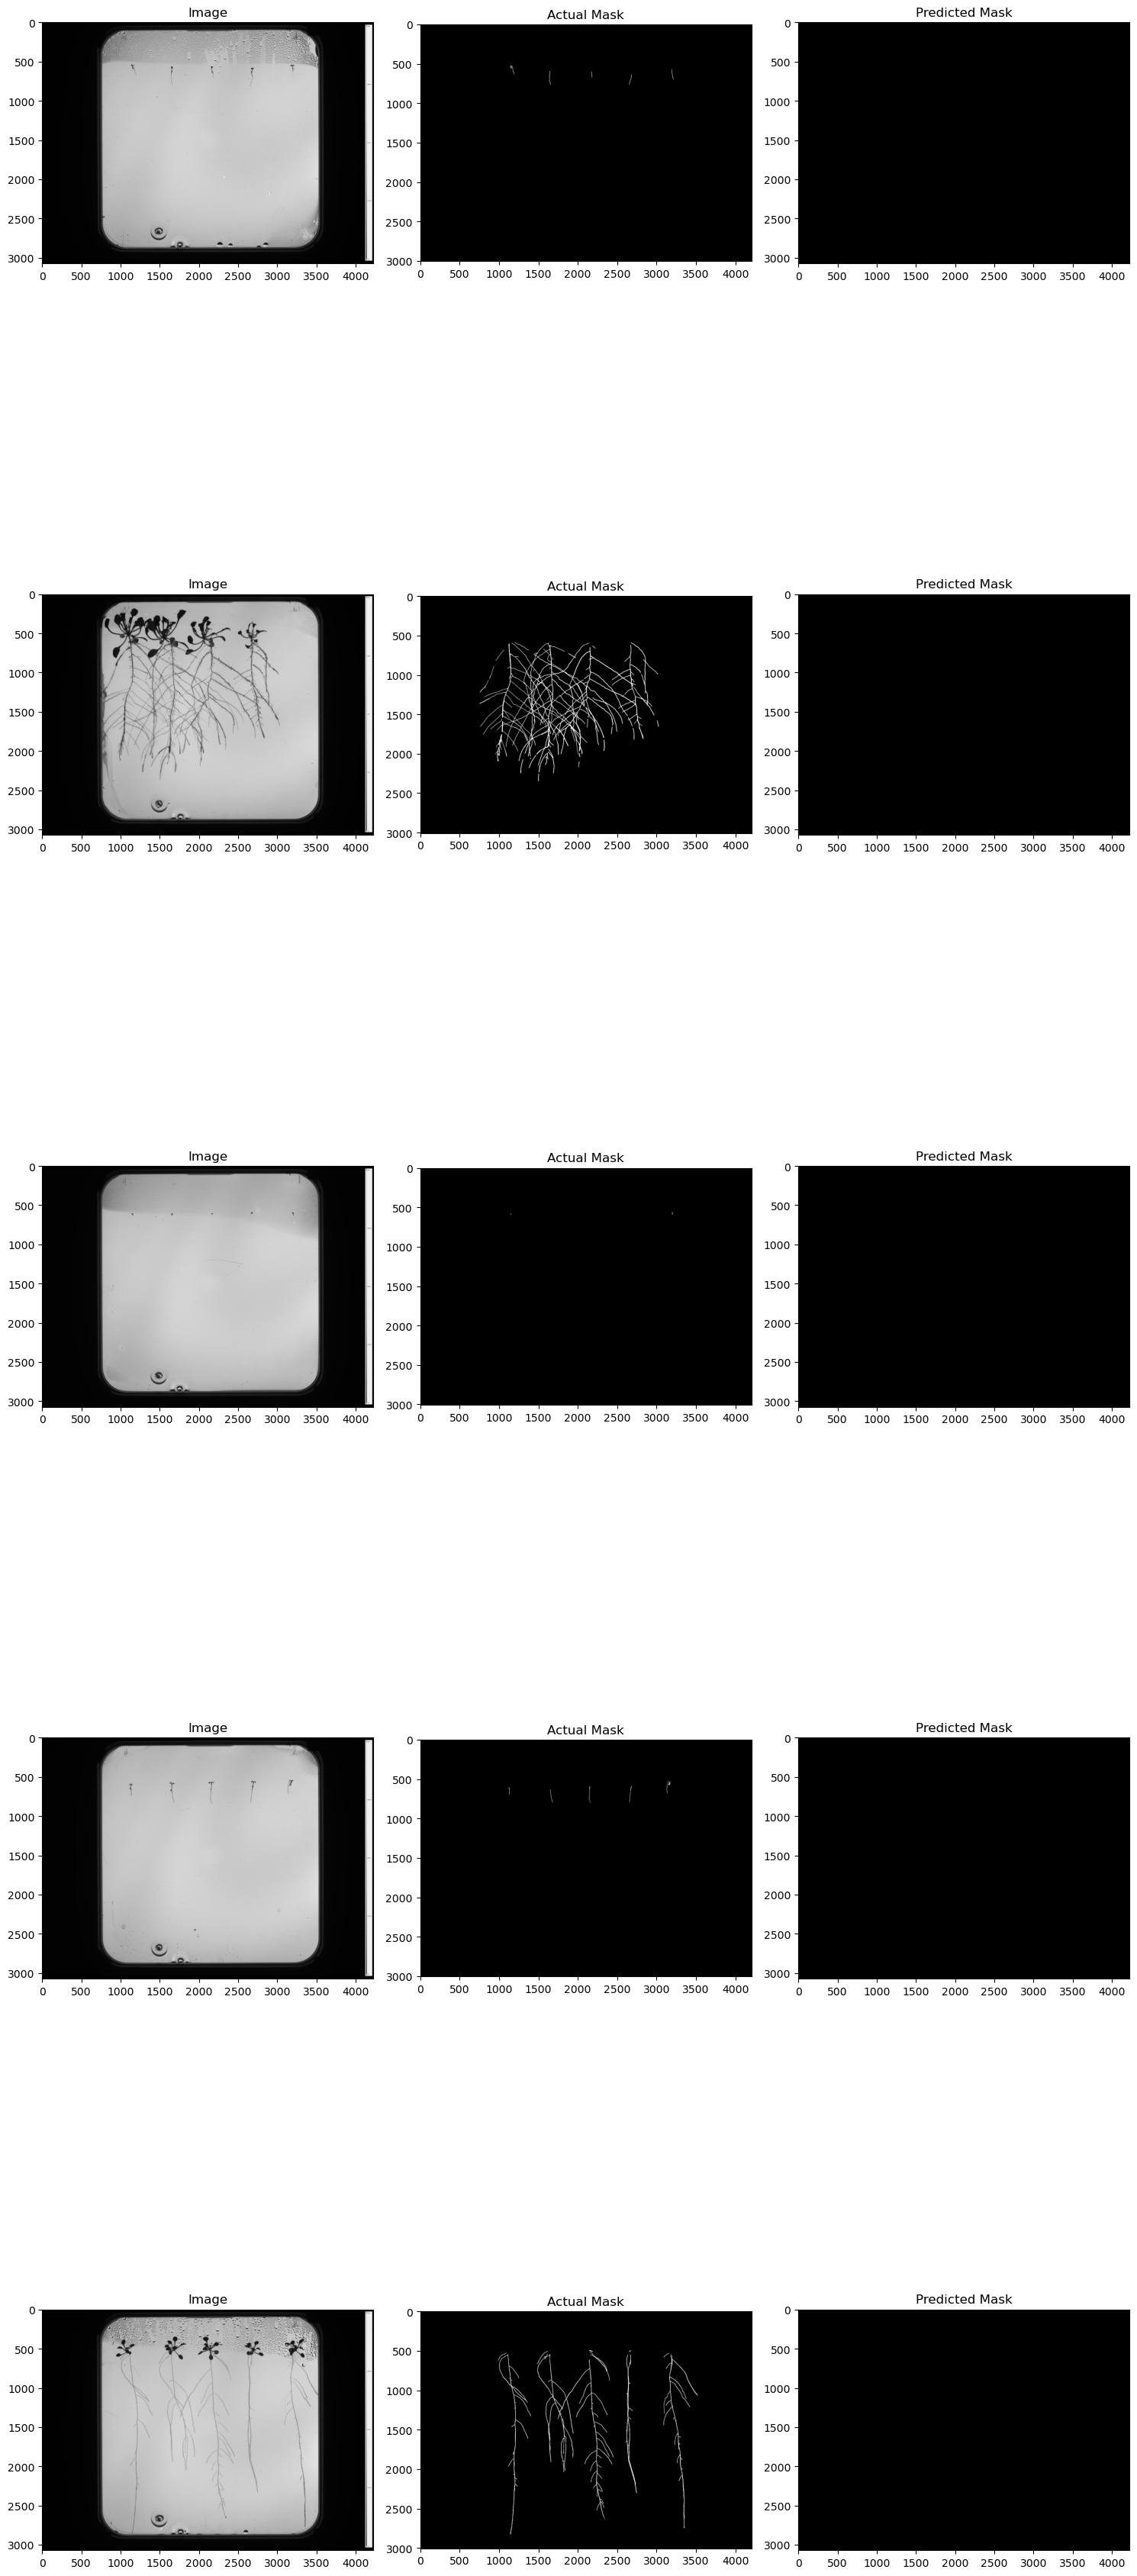

In [18]:
import cv2
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

def visualize_predictions(model, image_paths, mask_paths, patch_size=128):
    fig, axs = plt.subplots(len(image_paths), 3, figsize=(15, 8 * len(image_paths)))

    for idx, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = cv2.imread(image_path)
        image = padder(image, patch_size) 

        patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
        i, j = patches.shape[0], patches.shape[1]
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        preds = model_root.predict(patches / 255)
        preds = preds.reshape(i, j, 128, 128)

        predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))

        axs[idx, 0].imshow(image)
        axs[idx, 0].set_title('Image')

        mask = cv2.imread(mask_path, 0)  
        axs[idx, 1].imshow(mask, cmap='gray')
        axs[idx, 1].set_title('Actual Mask')

        axs[idx, 2].imshow(predicted_mask > 0.6, cmap='gray')  # Adjust threshold if needed
        axs[idx, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()


mask_paths = [
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_root_mask.tif',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected_root_mask.tif',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\005_43-2-ROOT1-2023-08-08_control_pH7_-Fe+B_col0_04-Fish Eye Corrected_root_mask.tif',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\006_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected_root_mask.tif',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\006_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_02-Fish Eye Corrected_root_mask.tif'
]


image_paths = [
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected.png',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected.png',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\005_43-2-ROOT1-2023-08-08_control_pH7_-Fe+B_col0_04-Fish Eye Corrected.png',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\006_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected.png',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\006_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_02-Fish Eye Corrected.png'
]

visualize_predictions(model_root, image_paths, mask_paths)


Training model for shoots

In [19]:
mask_type = 'shoot'

In [20]:
patch_dir = 'Images for model/shoot_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)


In [21]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)

In [22]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Training masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.


In [23]:
from keras.callbacks import EarlyStopping
model_shoot = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_iou',
                   patience=2,
                   restore_best_weights='True',
                   mode='max')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 128, 128, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_54 (Dropout)           (None, 128, 128, 16  0           ['conv2d_114[0][0]']             
                                )                                                           

In [24]:
h = model_shoot.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=10,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/10


1980/1980 [==============================] - 212s 105ms/step - loss: 0.0283 - accuracy: 0.9948 - f1: 2.3105e-04 - iou: 0.1133 - val_loss: 0.0093 - val_accuracy: 0.9974 - val_f1: 2.4245e-04 - val_iou: 0.2913
Epoch 2/10
1980/1980 [==============================] - 194s 98ms/step - loss: 0.0447 - accuracy: 0.9948 - f1: 0.0075 - iou: 0.0490 - val_loss: 0.0089 - val_accuracy: 0.9974 - val_f1: 0.0104 - val_iou: 0.0046
Epoch 3/10
1980/1980 [==============================] - 131s 66ms/step - loss: 0.0148 - accuracy: 0.9951 - f1: 0.0816 - iou: 0.0096 - val_loss: 0.0078 - val_accuracy: 0.9975 - val_f1: 0.0786 - val_iou: 0.0072


In [25]:
cb = EarlyStopping(monitor='val_iou',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
histories = [] # for plotting val_loss vs epochs for each learning rate
best_val_ious = [] # for plotting best_val_loss vs learning rate
for lr in learning_rates:
    print('Training with: ', lr)
    model = simple_unet_model(patch_size, patch_size, 1)
    model = compile_model(model, lr=lr)

    H = model_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb])   
 
       
    best_metrics = model.evaluate(val_generator, steps=val_image_generator.samples // 16)
    
    best_val_iou = best_metrics[3]  
    best_val_ious.append(best_val_iou)
    histories.append(H.history["val_loss"])

Training with:  0.01
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 128, 128, 16  160         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_63 (Dropout)           (None, 128, 128, 16  0           ['conv2d_133[0][0]']             
                                )                                      

KeyboardInterrupt: 

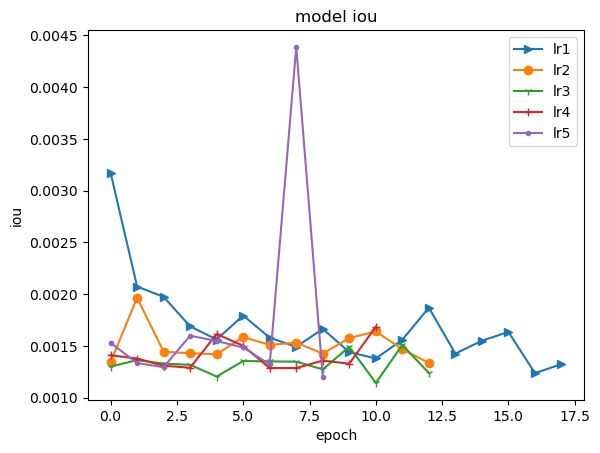

In [ ]:
plt.plot(histories[0], marker = ">")
plt.plot(histories[1], marker = "o")
plt.plot(histories[2], marker = "1")
plt.plot(histories[3], marker = "+")
plt.plot(histories[4], marker = ".")
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['lr1', 'lr2', 'lr3', 'lr4', 'lr5'], loc='upper right')
plt.show()

Training model for seeds

In [ ]:
mask_type = 'seed'

In [ ]:
patch_dir = 'Images for model/seed_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [ ]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)

In [ ]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Training masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.


In [ ]:
from keras.callbacks import EarlyStopping
model_seed = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_iou',
                   patience=2,
                   restore_best_weights='True',
                   mode='max')

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_228 (Conv2D)            (None, 128, 128, 16  160         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_108 (Dropout)          (None, 128, 128, 16  0           ['conv2d_228[0][0]']             
                                )                                                          

In [ ]:
h = model_seed.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=10,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/10
1980/1980 [==============================] - 123s 61ms/step - loss: 1.2758 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.2774 - val_loss: 6.1674e-04 - val_accuracy: 1.0000 - val_f1: 0.0000e+00 - val_iou: 0.2976
Epoch 2/10
1980/1980 [==============================] - 117s 59ms/step - loss: 5.8503e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.3082 - val_loss: 3.3407e-04 - val_accuracy: 1.0000 - val_f1: 0.0000e+00 - val_iou: 0.3586
Epoch 3/10
1980/1980 [==============================] - 117s 59ms/step - loss: 0.0014 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.3176 - val_loss: 3.5399e-04 - val_accuracy: 1.0000 - val_f1: 0.0000e+00 - val_iou: 0.3321
Epoch 4/10
1980/1980 [==============================] - 122s 62ms/step - loss: 4.9985e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.2907 - val_loss: 3.3787e-04 - val_accuracy: 1.0000 - val_f1: 0.0000e+00 - val_iou: 0.3209


In [ ]:
cb = EarlyStopping(monitor='val_iou',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
histories = [] # for plotting val_loss vs epochs for each learning rate
best_val_ious = [] # for plotting best_val_loss vs learning rate
for lr in learning_rates:
    print('Training with: ', lr)
    model = simple_unet_model(patch_size, patch_size, 1)
    model = compile_model(model, lr=lr)

    H = model_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb])   
 
       
    best_metrics = model.evaluate(val_generator, steps=val_image_generator.samples // 16)
    
    best_val_iou = best_metrics[3]  
    best_val_ious.append(best_val_iou)
    histories.append(H.history["val_loss"])

Training with:  0.01
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_247 (Conv2D)            (None, 128, 128, 16  160         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_117 (Dropout)          (None, 128, 128, 16  0           ['conv2d_247[0][0]']             
                                )                                     

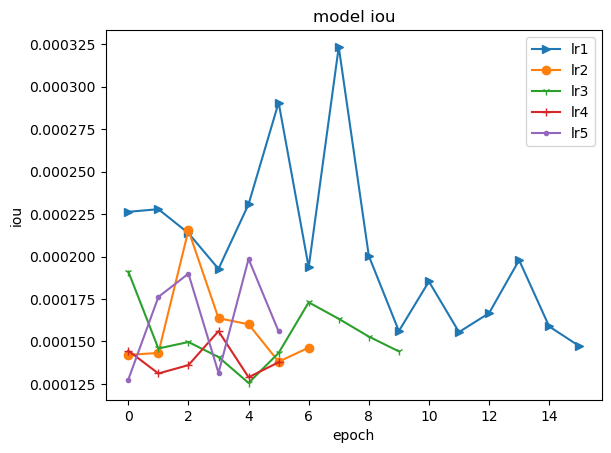

In [ ]:
plt.plot(histories[0], marker = ">")
plt.plot(histories[1], marker = "o")
plt.plot(histories[2], marker = "1")
plt.plot(histories[3], marker = "+")
plt.plot(histories[4], marker = ".")
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['lr1', 'lr2', 'lr3', 'lr4', 'lr5'], loc='upper right')
plt.show()

Training model for occluded_roots

In [ ]:
mask_type = 'occluded_root'

In [ ]:
patch_dir = 'Images for model/occluded_root_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [ ]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)

In [ ]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Training masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 31680 images belonging to 1 classes.
Found 29604 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.


In [ ]:
from keras.callbacks import EarlyStopping
model_occluded_root = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='val_iou',
                   patience=2,
                   restore_best_weights='True',
                   mode='max')

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_342 (Conv2D)            (None, 128, 128, 16  160         ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_162 (Dropout)          (None, 128, 128, 16  0           ['conv2d_342[0][0]']             
                                )                                                          

In [ ]:
h = model_occluded_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=10,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/10
1850/1980 [===========================>..] - ETA: 7s - loss: 0.0134 - accuracy: 0.9991 - f1: 6.6485e-07 - iou: 0.0300

InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/logistic_loss/mul' defined at (most recent call last):
    File "c:\Users\domin\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\domin\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\domin\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\domin\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\domin\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\domin\AppData\Local\Temp\ipykernel_6264\3635116283.py", line 1, in <module>
      h = model_occluded_root.fit(
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(
Node: 'binary_crossentropy/logistic_loss/mul'
required broadcastable shapes
	 [[{{node binary_crossentropy/logistic_loss/mul}}]] [Op:__inference_train_function_2861226]

In [ ]:
cb = EarlyStopping(monitor='val_iou',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
histories = [] # for plotting val_loss vs epochs for each learning rate
best_val_ious = [] # for plotting best_val_loss vs learning rate
for lr in learning_rates:
    print('Training with: ', lr)
    model = simple_unet_model(patch_size, patch_size, 1)
    model = compile_model(model, lr=lr)

    H = model_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb])   
 
       
    best_metrics = model.evaluate(val_generator, steps=val_image_generator.samples // 16)
    
    best_val_iou = best_metrics[3]  
    best_val_ious.append(best_val_iou)
    histories.append(H.history["val_loss"])

In [ ]:
plt.plot(histories[0], marker = ">")
plt.plot(histories[1], marker = "o")
plt.plot(histories[2], marker = "1")
plt.plot(histories[3], marker = "+")
plt.plot(histories[4], marker = ".")
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['lr1', 'lr2', 'lr3', 'lr4', 'lr5'], loc='upper right')
plt.show()

In [ ]:
test_images = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\test"

In [ ]:
def create_patches(image_path, patch_size):
    image = cv2.imread(image_path)
    patches = patchify(image, (patch_size[0], patch_size[1], 3), step=patch_size[0])  # Adjust patch_size tuple
    patches = patches.reshape(-1, patch_size[0], patch_size[1], 3)
    return patches

directory = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\test'

all_patches = []

# Process all images in the directory
for filename in os.listdir(directory):
    if filename.endswith('.png'):  
        image_path = os.path.join(directory, filename)
        patches = create_patches(image_path, patch_size=(128, 128, 3))  
        all_patches.append(patches)

In [ ]:
predicted_masks = []
for test_image in test_images:
    # Use your trained model to predict masks for each class
    predicted_mask_root = model_root.predict(test_image)
    predicted_mask_shoot = model_shoot.predict(test_image)
    predicted_mask_seed = model_seed.predict(test_image)
    predicted_mask_occluded_root = model_occluded_root.predict(test_image)
    # Repeat for other classes

    # Store the predicted masks for each class
    predicted_masks.append({
        'root': predicted_mask_root,
        'shoot': predicted_mask_shoot,
        'seed': predicted_mask_seed,
        'occluded_root': predicted_mask_occluded_root,
        })

IndexError: tuple index out of range

In [ ]:
image_path = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\test\035_43-14-ROOT1-2023-08-08_pvd_OD01_f6h1_03-Fish Eye Corrected.png'
image = cv2.imread(image_path)
image = padder(image, patch_size)

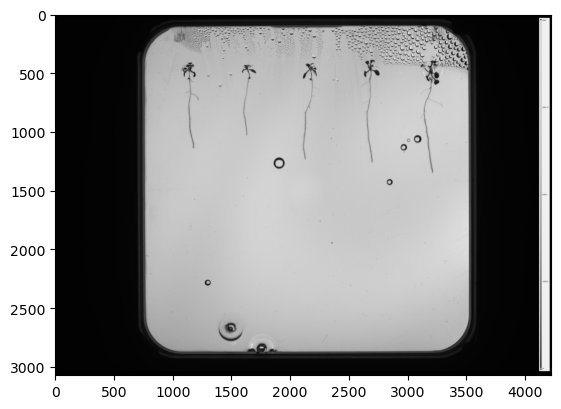

In [ ]:
plt.imshow(image)

In [ ]:
patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)


In [ ]:
i = patches.shape[0]
j = patches.shape[1]

In [ ]:
patches = patches.reshape(-1, patch_size, patch_size, 3)
patches.shape

(792, 128, 128, 3)

In [ ]:
preds = model_shoot.predict(patches/255)

25/25 [==============================] - 1s 41ms/step


In [ ]:
preds = preds.reshape(i, j, 128, 128)
preds.shape

(24, 33, 128, 128)

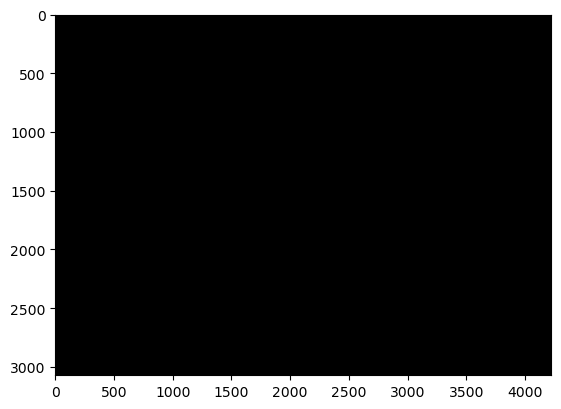

In [ ]:
predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
plt.imshow(predicted_mask>0.5, cmap='gray')